# Construction de graphe pour la détection de credential stuffing

Ce notebook permet de convertir les logs de connexion prétraités en une structure de graphe adaptée à l'utilisation de modèles GCN/VGAE pour la détection d'attaques de credential stuffing.

## Qu'est-ce que le credential stuffing?
Le credential stuffing est une attaque où un attaquant tente d'accéder à de nombreux comptes en utilisant des combinaisons de noms d'utilisateur/mots de passe volées. Un indicateur typique est une même adresse IP tentant d'accéder à un grand nombre de comptes différents.

In [15]:
# Import des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import torch

# Pour PyTorch Geometric (pour GCN/VGAE plus tard)
try:
    from torch_geometric.data import Data
except ImportError:
    print("PyTorch Geometric n'est pas installé. Installez-le avec:")
    print("pip install torch-geometric torch-scatter torch-sparse")

# Configuration pour les visualisations
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [16]:
# MODIFICATION : Charger le nouveau fichier de logs nettoyé
df = pd.read_csv("logs/logs_events_clean.csv")

# Affichage des premières lignes pour vérification
print("Aperçu des données de connexion :")
display(df.head())

# Vérification des colonnes disponibles
print("\nColonnes disponibles:")
print(df.columns.tolist())

Aperçu des données de connexion :


,id,user_id,timestamp,event_type,auth_type,ip_address,client_id,user_agent_hash,canal,city,country,login_status,user_conn_freq,ip_conn_freq,user_ua_diversity,ip_ua_diversity
0,AZcxur4c-ICzjV_NRK5f,8faacc5cd2534c2eb78f8cd2114fc6a66f543318d9974e...,2025-06-02 17:40:11.420000+00:00,login,password,674a135355e8b1e1e55b932e176415c3c85290676ff72c...,3efp2wUSJdNCaau1BAjS,a690ece263d309de1e2306391c6d5bf520fe29e8d50e1e...,identity_first_party,Lucca,Italy,success,1.0,1.000000,1,1
1,AZcxur4c-ICzjV_NRK5f,8faacc5cd2534c2eb78f8cd2114fc6a66f543318d9974e...,2025-06-02 17:40:11.420000+00:00,login,password,674a135355e8b1e1e55b932e176415c3c85290676ff72c...,3efp2wUSJdNCaau1BAjS,a690ece263d309de1e2306391c6d5bf520fe29e8d50e1e...,identity_first_party,Lucca,Italy,success,1.0,1.000000,1,1
2,AZcxur-7orOvtZtmN7R8,f7fd2b5c327cd330975ed6e1cf971126001579c3fe02c9...,2025-06-02 17:40:11.835000+00:00,login,refresh,cfd5065ab4d87895601e26bd782055667e7b9d033424b6...,vNm6E4T787EOcDObKj3R,7dd784295e588d22a36f9aa4661e813c2221eb945e9755...,identity_first_party,Brussels,Belgium,success,1.0,0.261724,1,1
3,AZcxur-7orOvtZtmN7R8,f7fd2b5c327cd330975ed6e1cf971126001579c3fe02c9...,2025-06-02 17:40:11.835000+00:00,login,refresh,cfd5065ab4d87895601e26bd782055667e7b9d033424b6...,vNm6E4T787EOcDObKj3R,7dd784295e588d22a36f9aa4661e813c2221eb945e9755...,identity_first_party,Brussels,Belgium,success,1.0,0.261724,1,1
4,AZcxusENH9C07pBMSrTc,3863d3bbf73743ac699f04838a7d29d81bc2a1e798463b...,2025-06-02 17:40:12.173000+00:00,login,refresh,fe14787607e69d705c79db451fa77bbe721ac9f1c55b6f...,3efp2wUSJdNCaau1BAjS,cbef514453fadaafc44470bef7f3c2df6ee4740d6e51b0...,identity_first_party,Brussels,Belgium,success,1.0,0.130202,1,1



Colonnes disponibles:
['id', 'user_id', 'timestamp', 'event_type', 'auth_type', 'ip_address', 'client_id', 'user_agent_hash', 'canal', 'city', 'country', 'login_status', 'user_conn_freq', 'ip_conn_freq', 'user_ua_diversity', 'ip_ua_diversity']


## Construction du graphe bipartite: IP <-> Utilisateurs

Nous allons construire un graphe bipartite où:
- Les nœuds sont soit des adresses IP, soit des utilisateurs
- Une arête entre une IP et un utilisateur représente une tentative de connexion

Ce type de structure est idéal pour détecter le credential stuffing car elle permet de visualiser facilement:
- Les IPs qui tentent d'accéder à un nombre anormalement élevé de comptes (attaquants potentiels)
- Les comptes qui sont ciblés par de nombreuses IPs différentes (cibles potentielles)

In [17]:
# 1. Construction du graphe pour la détection de credential stuffing
# Création d'un graphe bipartite: IP <-> Utilisateurs
G = nx.Graph()

# Identification des colonnes pertinentes (devraient être 'user_id' et 'ip_address')
user_col = 'user_id'
ip_col = 'ip_address'

# Ajout des noeuds IP
ip_addresses = df[ip_col].unique()
G.add_nodes_from(ip_addresses, type='ip')
print(f"Nombre de nœuds IP ajoutés: {len(ip_addresses)}")

# Ajout des noeuds utilisateur
users = df[user_col].unique()
G.add_nodes_from(users, type='user')
print(f"Nombre de nœuds Utilisateur ajoutés: {len(users)}")


# Ajout des arêtes pour les tentatives de connexion
for _, row in df.iterrows():
    ip_node = row[ip_col]
    user_node = row[user_col]
    
    # MODIFICATION : L'arête contient maintenant le statut de la connexion
    # Nous allons compter les succès et les échecs séparément sur chaque arête.
    
    is_success = 1 if row['login_status'] == 'success' else 0
    is_failure = 1 if row['login_status'] == 'failure' else 0
    
    # Si l'arête existe déjà, on met à jour les compteurs
    if G.has_edge(ip_node, user_node):
        G[ip_node][user_node]['count'] += 1
        G[ip_node][user_node]['success'] += is_success
        G[ip_node][user_node]['failure'] += is_failure
    # Sinon, on crée l'arête avec les attributs initiaux
    else:
        G.add_edge(
            ip_node, 
            user_node, 
            count=1, 
            success=is_success, 
            failure=is_failure,
            # On garde le premier timestamp de la connexion
            first_seen=row['timestamp'] 
        )

# Informations sur le graphe
print(f"\nGraphe construit avec {G.number_of_nodes()} nœuds et {G.number_of_edges()} arêtes.")

Nombre de nœuds IP ajoutés: 1889
Nombre de nœuds Utilisateur ajoutés: 12782

Graphe construit avec 14671 nœuds et 16387 arêtes.


In [18]:
# ===================================================================
# Cellule 4 : Calcul des caractéristiques du graphe (avec géo-features et comportementales)
# ===================================================================

# Calcul des caractéristiques du graphe utiles pour la détection
# On utilise le DataFrame original pour des calculs plus rapides
print("\nCalcul des caractéristiques pour les nœuds...")

# --- Caractéristiques de base (degré, tentatives, etc.) ---
for node in G.nodes():
    node_data = G.nodes[node]
    neighbors = list(G.neighbors(node))
    total_attempts = sum(G[node][neighbor]['count'] for neighbor in neighbors)
    total_failures = sum(G[node][neighbor]['failure'] for neighbor in neighbors)
    
    node_data['total_attempts'] = total_attempts
    node_data['failure_rate'] = total_failures / max(1, total_attempts)

    if node_data['type'] == 'ip':
        node_data['unique_users_attempted'] = len(neighbors)
    else: # 'user'
        node_data['unique_ips_connected'] = len(neighbors)

# --- Calcul des caractéristiques géographiques ---
ip_geo_stats = df.groupby('ip_address').agg(
    num_countries=('country', 'nunique'),
    num_cities=('city', 'nunique')
).reset_index()

user_geo_stats = df.groupby('user_id').agg(
    num_countries=('country', 'nunique'),
    num_cities=('city', 'nunique')
).reset_index()

for _, row in ip_geo_stats.iterrows():
    if row['ip_address'] in G:
        G.nodes[row['ip_address']]['num_countries'] = row['num_countries']
        G.nodes[row['ip_address']]['num_cities'] = row['num_cities']
        
for _, row in user_geo_stats.iterrows():
    if row['user_id'] in G:
        G.nodes[row['user_id']]['num_countries'] = row['num_countries']
        G.nodes[row['user_id']]['num_cities'] = row['num_cities']

# --- NOUVEAU : Calcul des caractéristiques comportementales ---
required_cols = ['ip_conn_freq', 'ip_ua_diversity', 'user_conn_freq', 'user_ua_diversity']
if all(col in df.columns for col in required_cols):
    print("Calcul des caractéristiques comportementales...")
    ip_behavior_stats = df.groupby('ip_address').agg(
        conn_freq=('ip_conn_freq', 'first'),
        ua_diversity=('ip_ua_diversity', 'first')
    ).reset_index()

    user_behavior_stats = df.groupby('user_id').agg(
        conn_freq=('user_conn_freq', 'first'),
        ua_diversity=('user_ua_diversity', 'first')
    ).reset_index()

    for _, row in ip_behavior_stats.iterrows():
        if row['ip_address'] in G:
            G.nodes[row['ip_address']]['conn_freq'] = row['conn_freq']
            G.nodes[row['ip_address']]['ua_diversity'] = row['ua_diversity']

    for _, row in user_behavior_stats.iterrows():
        if row['user_id'] in G:
            G.nodes[row['user_id']]['conn_freq'] = row['conn_freq']
            G.nodes[row['user_id']]['ua_diversity'] = row['ua_diversity']

    print("Caractéristiques comportementales ajoutées aux nœuds.")
else:
    print("Colonnes de caractéristiques comportementales non trouvées. Saute cette étape.")

print("Caractéristiques calculées pour les nœuds.")
sample_ip = list(ip_addresses)[0]
print(f"Exemple de caractéristiques pour l'IP {sample_ip}: {G.nodes[sample_ip]}")


Calcul des caractéristiques pour les nœuds...
Calcul des caractéristiques comportementales...
Caractéristiques comportementales ajoutées aux nœuds.
Caractéristiques calculées pour les nœuds.
Exemple de caractéristiques pour l'IP 674a135355e8b1e1e55b932e176415c3c85290676ff72ce8a7d14db986becc84: {'type': 'ip', 'total_attempts': 2, 'failure_rate': 0.0, 'unique_users_attempted': 1, 'num_countries': 1, 'num_cities': 1, 'conn_freq': 1.0, 'ua_diversity': 1}


## Visualisation du graphe de connexion

La visualisation ci-dessous permet de voir les relations entre les IPs et les utilisateurs dans un graphe bipartite. Dans ce graphe:

- Les **nœuds rouges** représentent les adresses IP - plus ils sont rouges, plus ils tentent d'accéder à un nombre élevé d'utilisateurs différents (comportement suspect)

- Les **nœuds bleus** représentent les comptes utilisateurs - plus ils sont bleus, plus ils sont accédés depuis de nombreuses IPs différentes (potentiellement ciblés)

- Les **liens gris** entre les nœuds représentent les tentatives de connexion

Dans un scénario de credential stuffing, on s'attend à voir certaines IPs (nœuds rouges) connectées à un nombre anormalement élevé d'utilisateurs différents. Ces IPs apparaissent généralement comme des "hubs" avec de nombreuses connexions sortantes.

**Comment interpréter le graphe**:
1. Les IPs les plus rouges et avec le plus de connexions sont des suspects potentiels de credential stuffing
2. Les utilisateurs les plus bleus sont potentiellement les cibles d'attaques
3. La densité des connexions indique l'intensité de l'activité de connexion

Note: Si le graphe est trop grand, nous ne visualiserons qu'un sous-ensemble pour des raisons de lisibilité.

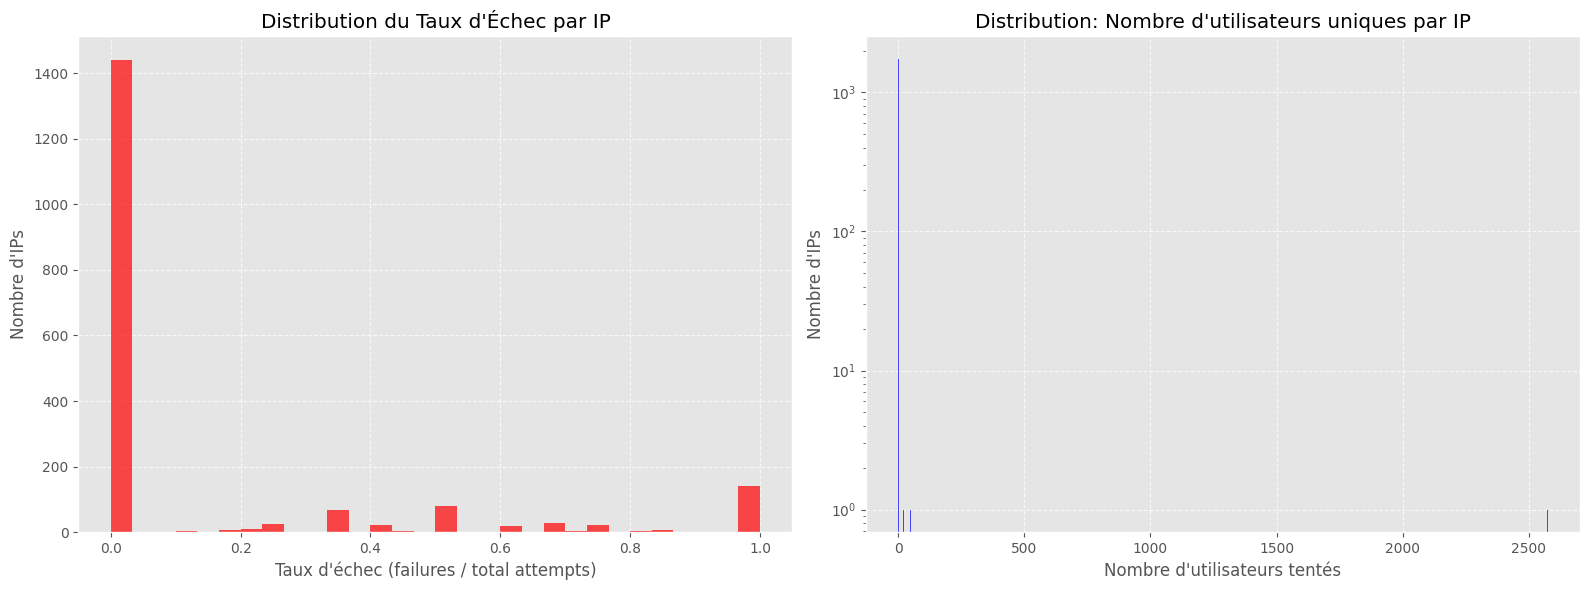

In [19]:
# Distribution des nouvelles caractéristiques
ip_failure_rates = [G.nodes[node]['failure_rate'] 
                     for node in G.nodes() if G.nodes[node]['type'] == 'ip']
ip_users_attempted = [G.nodes[node]['unique_users_attempted'] 
                     for node in G.nodes() if G.nodes[node]['type'] == 'ip']

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Histogramme: Taux d'échec par IP
ax[0].hist(ip_failure_rates, bins=30, color='red', alpha=0.7)
ax[0].set_title('Distribution du Taux d\'Échec par IP')
ax[0].set_xlabel('Taux d\'échec (failures / total attempts)')
ax[0].set_ylabel('Nombre d\'IPs')
ax[0].grid(True, linestyle='--', alpha=0.7)

# Histogramme: nombre d'utilisateurs uniques par IP
ax[1].hist(ip_users_attempted, bins=range(1, max(ip_users_attempted, default=2) + 2), color='blue', alpha=0.7, align='left')
ax[1].set_title('Distribution: Nombre d\'utilisateurs uniques par IP')
ax[1].set_xlabel('Nombre d\'utilisateurs tentés')
ax[1].set_ylabel('Nombre d\'IPs')
ax[1].set_yscale('log') # Échelle logarithmique pour mieux voir les IPs suspectes
ax[1].grid(True, linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

## Préparation des données pour GCN/VGAE

Pour utiliser des modèles de Graph Neural Networks comme GCN (Graph Convolutional Network) ou VGAE (Variational Graph Auto-Encoder), nous devons convertir notre graphe NetworkX au format PyTorch Geometric.

Cela implique de créer:
1. Une matrice de caractéristiques pour chaque nœud
2. Une structure d'index d'arêtes pour représenter la connectivité du graphe
3. Des attributs d'arêtes pour capturer des informations supplémentaires

Le graphe est trop grand (14671 nœuds), visualisation d'un sous-ensemble.
Affichage d'un sous-graphe de 50 nœuds et 48 arêtes.


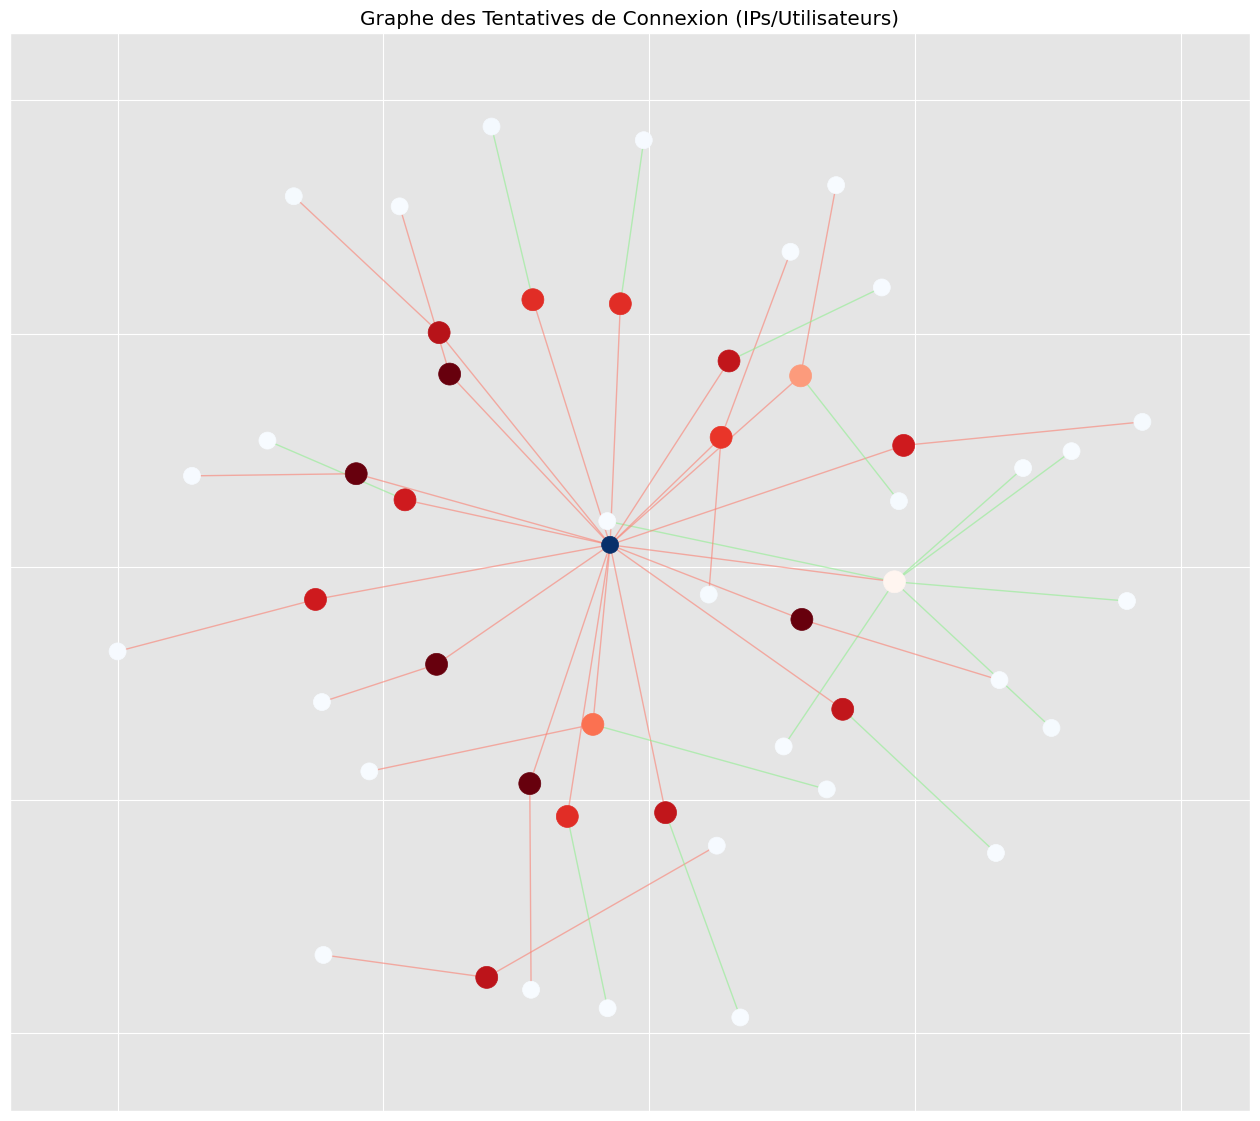

In [20]:
plt.figure(figsize=(16, 14))

# Filtrer le graphe pour la visualisation
# On se base sur les IPs qui ont le plus de connexions ou le plus haut taux d'échec
max_nodes_to_display = 100

if G.number_of_nodes() > max_nodes_to_display:
    print(f"Le graphe est trop grand ({G.number_of_nodes()} nœuds), visualisation d'un sous-ensemble.")
    
    # Sélectionner les IPs les plus suspectes (beaucoup d'utilisateurs tentés ET taux d'échec élevé)
    ip_nodes_with_scores = [
        (node, G.nodes[node]['unique_users_attempted'] * G.nodes[node]['failure_rate'])
        for node in G.nodes() if G.nodes[node]['type'] == 'ip'
    ]
    ip_nodes_with_scores.sort(key=lambda x: x[1], reverse=True)
    
    top_ips = [node for node, score in ip_nodes_with_scores[:20]] # On prend les 20 plus suspectes
    
    user_nodes_to_include = []
    for ip in top_ips:
        user_nodes_to_include.extend(list(G.neighbors(ip)))
        
    nodes_to_include = list(set(top_ips + user_nodes_to_include))
    
    # Limiter la taille si c'est encore trop grand
    if len(nodes_to_include) > max_nodes_to_display:
        nodes_to_include = nodes_to_include[:max_nodes_to_display]
        
    G_vis = G.subgraph(nodes_to_include)
    print(f"Affichage d'un sous-graphe de {G_vis.number_of_nodes()} nœuds et {G_vis.number_of_edges()} arêtes.")
else:
    G_vis = G

# --- Reste du code de visualisation (adapté pour les nouvelles caractéristiques) ---
pos = nx.spring_layout(G_vis, seed=42, k=0.5)

# Nœuds IP et Utilisateur
ip_nodes_vis = [n for n, d in G_vis.nodes(data=True) if d['type'] == 'ip']
user_nodes_vis = [n for n, d in G_vis.nodes(data=True) if d['type'] == 'user']

# Dessiner les nœuds IP
# MODIFICATION: Colorer par taux d'échec
ip_colors = [G_vis.nodes[node].get('failure_rate', 0) for node in ip_nodes_vis]
nx.draw_networkx_nodes(G_vis, pos, nodelist=ip_nodes_vis, node_color=ip_colors, cmap=plt.cm.Reds, node_size=250, label="IPs")

# Dessiner les nœuds Utilisateur
user_colors = [G_vis.nodes[node].get('unique_ips_connected', 0) for node in user_nodes_vis]
nx.draw_networkx_nodes(G_vis, pos, nodelist=user_nodes_vis, node_color=user_colors, cmap=plt.cm.Blues, node_size=150, label="Utilisateurs")

# Dessiner les arêtes
# MODIFICATION: colorer les arêtes en fonction de succès/échec
edge_colors = []
for u, v in G_vis.edges():
    if G_vis[u][v]['failure'] > G_vis[u][v]['success']:
        edge_colors.append('salmon') # Rouge pour les connexions majoritairement échouées
    else:
        edge_colors.append('lightgreen') # Vert pour les succès

nx.draw_networkx_edges(G_vis, pos, edge_color=edge_colors, alpha=0.6)

plt.title("Graphe des Tentatives de Connexion (IPs/Utilisateurs)")
plt.show()

In [21]:
# ===================================================================
# Cellule 7 : Conversion au format PyTorch Geometric (avec géo-features et comportementales)
# ===================================================================

# Liste ordonnée des noeuds pour créer un mapping
node_list = list(G.nodes())
node_to_idx = {node: i for i, node in enumerate(node_list)}
idx_to_node = {i: node for node, i in node_to_idx.items()}

# Création des caractéristiques des noeuds
node_features = []
for node in node_list:
    node_data = G.nodes[node]
    features = []
    
    # Indicateur de type (one-hot)
    is_ip = 1 if node_data['type'] == 'ip' else 0
    features.extend([is_ip, 1 - is_ip])
    
    # Caractéristiques communes
    features.append(G.degree(node))
    features.append(node_data.get('total_attempts', 0))
    features.append(node_data.get('failure_rate', 0))
    
    # Caractéristiques spécifiques au type
    if node_data['type'] == 'ip':
        features.append(node_data.get('unique_users_attempted', 0))
    else: # type == 'user'
        features.append(node_data.get('unique_ips_connected', 0))
        
    # Caractéristiques géographiques
    features.append(node_data.get('num_countries', 0))
    features.append(node_data.get('num_cities', 0))

    # NOUVEAU : Ajout des caractéristiques comportementales
    features.append(node_data.get('conn_freq', 0))
    features.append(node_data.get('ua_diversity', 0))
        
    node_features.append(features)

# Conversion en tenseurs
x = torch.tensor(node_features, dtype=torch.float)

# Création de l'indice d'arêtes et des attributs
edge_index_list = []
edge_attr_list = []
for u, v, data in G.edges(data=True):
    src_idx = node_to_idx[u]
    dst_idx = node_to_idx[v]
    edge_index_list.extend([[src_idx, dst_idx], [dst_idx, src_idx]])
    
    edge_features = [data['count'], data['success'], data['failure']]
    edge_attr_list.extend([edge_features, edge_features])

edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)

# Création de l'objet Data PyG
pyg_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

print("\n(v4) Graphe PyTorch Geometric créé avec caractéristiques comportementales :")
print(pyg_data)
print(f"Nombre de caractéristiques par nœud : {pyg_data.num_node_features}") # Devrait maintenant être 10
print(f"Nombre de caractéristiques par arête : {pyg_data.num_edge_features}")

# MODIFICATION : Sauvegarde du graphe et du mapping sous de nouveaux noms (v4)
output_graph_path = 'construction/credential_stuffing_graph_v4.pt'
output_mapping_path = 'construction/node_mapping_v4.pt'
torch.save(pyg_data, output_graph_path)
torch.save(idx_to_node, output_mapping_path)
print(f"\nFichiers '{output_graph_path}' et '{output_mapping_path}' sauvegardés.")


(v4) Graphe PyTorch Geometric créé avec caractéristiques comportementales :
Data(x=[14671, 10], edge_index=[2, 32774], edge_attr=[32774, 3])
Nombre de caractéristiques par nœud : 10
Nombre de caractéristiques par arête : 3

Fichiers 'construction/credential_stuffing_graph_v4.pt' et 'construction/node_mapping_v4.pt' sauvegardés.


## Conclusion et Étapes Suivantes

Nous avons maintenant:
1. Construit un graphe bipartite représentant les interactions entre IPs et utilisateurs
2. Calculé des caractéristiques pertinentes pour chaque nœud
3. Identifié des comportements potentiellement suspects liés au credential stuffing
4. Préparé les données pour l'apprentissage avec des modèles GCN/VGAE

### Prochaines étapes

1. **Modélisation avec GCN/VGAE**:
   - Implémenter un modèle GCN ou VGAE pour apprendre la structure normale du graphe
   - Détecter les anomalies sur la base des erreurs de reconstruction ou des embeddings

2. **Évaluation des résultats**:
   - Comparer les anomalies détectées avec les comportements suspects identifiés
   - Analyser les faux positifs et faux négatifs

3. **Visualisation des embeddings**:
   - Projeter les embeddings des nœuds dans un espace 2D pour visualiser les clusters
   - Identifier visuellement les comportements anormaux